In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import pickle
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate, Lambda, BatchNormalization
from keras import metrics
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tensorflow.keras.utils import plot_model
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard

In [ ]:
class PreProcessing:

  def __init__(self, data_path, verbose=True):
      self.X=[]
      self.names=[]
      self.train_images = []
      self.verbose = verbose
      self.data_path = data_path
      self.train_path = os.path.join(self.data_path, 'archive')
      self.train_pickle = os.path.join(self.data_path, 'train.pickle')
      if not os.path.exists(self.train_path):
          with ZipFile(self.train_path + '.zip', 'r') as zip:
              if verbose: print('Extracting image lfw dataset...')
              zip.extractall()
              if verbose: print('Image Background Extracted')



      print('loading images')
      self.train_images = self.load_image(self.train_path)
      #self.save_pickle('train.pickle', self.train_images)

  def load_image(self, path):
      path = '/content/archive/Archive'
      if self.verbose:
          print('Loading Image From ', path)

      for alphabet in os.listdir(path):
          if self.verbose:
              print("Loading Images : ", alphabet)
          alphabet_path = os.path.join(path, alphabet)
          classes=0
          for letter in os.listdir(alphabet_path):
              
              if classes>480:
                break
              print(letter)
              letter_path = os.path.join(alphabet_path, letter)
              letter_images = []
              l=0
              for filename in os.listdir(letter_path):
                  l=l+1
                  print(filename)
                  file_path = os.path.join(letter_path, filename)
                  img = cv2.imread(file_path)
                  #plt.imshow(img)
                  #if l==8:
                    #cv2_imshow(img)
                  try:
                    img = cv2.resize(img, (299, 299))
                    img = img / 255
                  except:
                    continue
                  letter_images.append(img)
                  if l==5:
                      classes = classes+1
                      #cv2_imshow(img)
                      l=0
                      try:
                          self.X.append(np.stack(letter_images))
                          self.names.append(letter)
                      except ValueError as e:
                          print(e)
                      break

      self.X = np.stack(self.X)
      print('done loading')
      print(np.shape(self.X))
      return self.X


  def save_pickle(self, pickle_name, obj):
      with open(os.path.join(self.data_path, pickle_name), "wb") as f:
          pickle.dump(obj, f)

  def get_triplet(self, shape):
      class_1 = random.randint(0, shape[0] - 1)
      class_2 = random.randint(0, shape[0] - 1)
      if(class_1==class_2):
        class_2 = random.randint(0, shape[0] - 1)
      a, p = (class_1, random.randint(0, shape[1] - 1)), (class_1, random.randint(0, shape[1] - 1))
      n = (class_2, random.randint(0, shape[1] - 1))
      #print(a, p, n)
      return a, p, n



  def get_triplet_batch(self, batch_size, train_data=True):
      anchor_image = []
      positive_image = []
      negative_image = []
      X = self.train_images
      for _ in range(batch_size):
          ida, idp, idn = self.get_triplet(X.shape)
          anchor_image.append(X[ida])
          positive_image.append(X[idp])
          negative_image.append(X[idn])

      ai = np.array(anchor_image)
      pi = np.array(positive_image)
      ni = np.array(negative_image)
      return [ai, pi, ni]


In [ ]:
data_path = r'/content/drive/MyDrive/DL/vgg16'
preprocess_data = PreProcessing(data_path, verbose=True)

Extracting image lfw dataset...
Image Background Extracted
loading images
Loading Image From  /content/archive/Archive
Loading Images :  lfw_cut
TD_RGB_A_Set393
cropped__2277.jpg
cropped__2315.jpg
cropped__2265.jpg
cropped__2331.jpg
cropped__2329.jpg
203
02.jpg
05.jpg
10.jpg
01.jpg
03.jpg
199
02.jpg
05.jpg
10.jpg
01.jpg
03.jpg
374
02.jpg
05.jpg
10.jpg
01.jpg
03.jpg
406
02.jpg
05.jpg
10.jpg
01.jpg
03.jpg
John_Manley
John_Manley_0006.jpg
John_Manley_0002.jpg
John_Manley_0007.jpg
John_Manley_0004.jpg
John_Manley_0003.jpg
Sheryl_Crow
Sheryl_Crow_0002.jpg
Sheryl_Crow_0007.jpg
Sheryl_Crow_0008.jpg
Sheryl_Crow_0003.jpg
Sheryl_Crow_0004.jpg
187
02.jpg
05.jpg
10.jpg
01.jpg
03.jpg
added1_TD_RGB_A_Set323
1624.jpg
1924.jpg
2052.jpg
988.jpg
2633.jpg
224
02.jpg
05.jpg
10.jpg
01.jpg
03.jpg
Mary_Steenburgen
Mary_Steenburgen_0002.jpg
Mary_Steenburgen_0001.jpg
Mary_Steenburgen_0003.jpg
Paul_Patton
Paul_Patton_0001.jpg
Paul_Patton_0002.jpg
Prince_Harry
Prince_Harry_0001.jpg
Prince_Harry_0003.jpg
Prince_H

In [ ]:
batch_size = 6
anchor_image, positive_image, negative_image = preprocess_data.get_triplet_batch(batch_size,train_data=True)

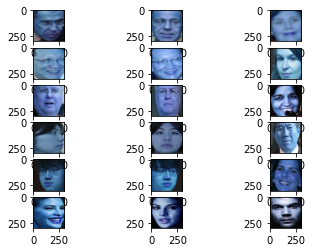

In [ ]:
fig, ax = plt.subplots(nrows=batch_size, ncols=3)
for i in range(batch_size):
    ax[i, 0].imshow(anchor_image[i])
    ax[i, 1].imshow(positive_image[i])
    ax[i, 2].imshow(negative_image[i])
plt.show()

In [ ]:
anchor_image.shape

(6, 299, 299, 3)

MODEL START


In [ ]:
'''model = tf.keras.applications.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), pooling=None, classes=1000,
    classifier_activation=None)
'''

'''emb_size = 2048
embedding_model = Sequential()
embedding_model.add(Conv2D(64, (10,10), activation='relu', input_shape=(224,224,3)))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(128, (7,7), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(128, (4,4), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(256, (4,4), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(Flatten())
embedding_model.add(Dense(emb_size, activation='sigmoid'))
embedding_model.add(Lambda(lambda x:tf.keras.backend.l2_normalize(x, axis=1)))
embedding_model.summary()'''

embedding_model = tf.keras.applications.InceptionResNetV2(
    include_top=True, weights=  None, input_tensor=None,
    input_shape=None, pooling=None, classes=128,
    classifier_activation=None,
)
embedding_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
in_anc = Input(shape=(299,299,3))
in_pos = Input(shape=(299,299,3))
in_neg = Input(shape=(299,299,3))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out= concatenate([em_anc, em_pos, em_neg], axis=1)
emb_size = 128
siamese_net = Model(inputs= [in_anc,in_pos,in_neg], outputs= out)
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 128)          54533472    input_2[0][0]                    
                                                                 input_3[0][0]                

In [ ]:

# L2 Distance
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.))
    return loss
def data_generator(batch_size, emb_size):
    while True:
        x = preprocess_data.get_triplet_batch(batch_size)
        y = np.zeros((batch_size, 3*int(emb_size),1), dtype=np.float32)
        yield x,y    



batch_size = 16
epochs =5
opt = tf.keras.optimizers.Adam(lr = 0.001)
steps_per_epoch = 1000
#emb_size = 1000

siamese_net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_size), optimizer=opt)
#print(model.summary())


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard

checkpoint_path = '/content/drive/MyDrive/DL/vgg16/inceptionresnetv2_4pm_13_march_{epoch}.tf'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
siamese_net.output
plot_model(embedding_model,show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.517941 to fit
tcmalloc: large alloc 1175650304 bytes == 0x559ec0532000 @  0x7efdea3f4001 0x7efde668b1fa 0x7efde668b2ad 0x7efde78166df 0x7efde7d0d261 0x7efdea18a468 0x7efdea18cd53 0x559ebd279092 0x7efde9b3fbf7 0x559ebd27912a



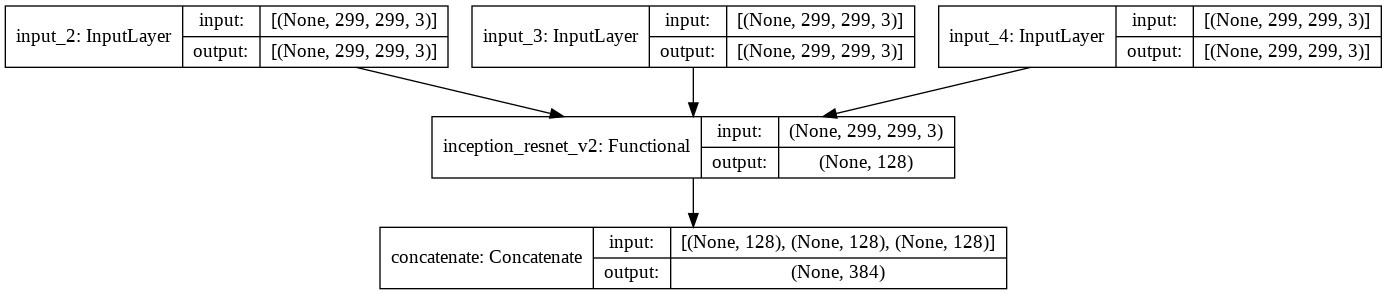

In [ ]:
siamese_net.output
plot_model(siamese_net,show_shapes=True)

In [ ]:
save_path = os.path.join("/content/drive/MyDrive/DL/vgg16/inceptionresnetv2_13march_4pm_feb.h5")
siamese_net.load_weights('/content/drive/MyDrive/DL/vgg16/inceptionresnetv2_11pm_12_march_7.tf')

In [ ]:
model_history = siamese_net.fit(
    data_generator(batch_size, emb_size),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=1,callbacks=[cp_callback])

Epoch 1/5
1000/1000 [==============================] - 1664s 2s/step - loss: 0.0123

Epoch 00001: saving model to /content/drive/MyDrive/DL/vgg16/inceptionresnetv2_4pm_13_march_1.tf
Epoch 2/5
 763/1000 [=====================>........] - ETA: 6:23 - loss: 0.0067

In [ ]:
#save_path = os.path.join("/content/drive/MyDrive/DL/vgg16/mode15_weights_siamese_vgg16.h5")
siamese_net.save_weights(save_path)

MODEL END

In [ ]:
print(model_history.history['loss'])

[0.01754201017320156, 0.00740983709692955, 0.008030740544199944, 0.005140482913702726, 0.0032342527993023396, 0.005738584790378809, 0.0030761882662773132, 0.0034749386832118034, 0.004359404556453228, 0.0034939113538712263]


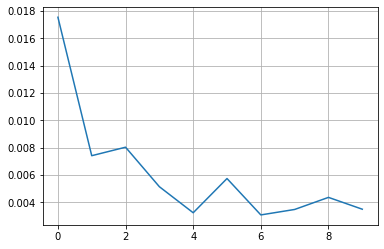

In [ ]:
plt.plot(model_history.history['loss'], label='Loss')
plt.grid(True)
plt.show()

In [ ]:
test_sample = 100
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
nway=50
print("Checking %d way accuracy...." %nway)
correct_count = 0
for _ in range(test_sample):
  # Retrieving nway number of triplets and calculating embedding vector
  nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=False)
  nway_anchor_embedding = embedding_model.predict(nway_anchor)
  sample_index = random.randint(0,nway-1)
  sample_embedding = embedding_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
  # print(sample_index, nway_anchor_embedding.shape, sample_embedding.shape)
  distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
  k=np.argmin(distance)
  if np.argmin(distance) == sample_index:
    correct_count+=1
  nway_list.append(nway)

  print(sample_index,"<-input : output ->",k)
acc = (correct_count//content/drive/MyDrive/DL/vgg16/inceptionresnetv2_24_11pm_feb.h5test_sample)*100.
print("Accuracy %.2f" % acc)


Checking 50 way accuracy....
10 <-input : output -> 36
23 <-input : output -> 26
39 <-input : output -> 25
2 <-input : output -> 10
9 <-input : output -> 30
42 <-input : output -> 42
14 <-input : output -> 2
21 <-input : output -> 49
41 <-input : output -> 2
38 <-input : output -> 38
8 <-input : output -> 8
40 <-input : output -> 40
25 <-input : output -> 14
2 <-input : output -> 2
9 <-input : output -> 9
39 <-input : output -> 39
9 <-input : output -> 9
45 <-input : output -> 29
15 <-input : output -> 4
28 <-input : output -> 1
18 <-input : output -> 35
26 <-input : output -> 35
44 <-input : output -> 30
15 <-input : output -> 15
44 <-input : output -> 0
30 <-input : output -> 15
49 <-input : output -> 13
6 <-input : output -> 44
38 <-input : output -> 0
2 <-input : output -> 33
29 <-input : output -> 5
15 <-input : output -> 15
16 <-input : output -> 41
28 <-input : output -> 5
5 <-input : output -> 5
43 <-input : output -> 7
4 <-input : output -> 4
32 <-input : output -> 1
23 <-inpu

NameError: ignored

In [ ]:
test_sample = 100
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    # Retrieving nway number of triplets and calculating embedding vector
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=True)
    #print(np.shape(nway_anchor))
    nway_anchor_embedding = embedding_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = embedding_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    # print(sample_index, nway_anchor_embedding.shape, sample_embedding.shape)
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  train_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
Accuracy 73.00
Checking 10 way accuracy....
Accuracy 63.00
Checking 15 way accuracy....
Accuracy 54.00
Checking 20 way accuracy....
Accuracy 54.00
Checking 25 way accuracy....
Accuracy 48.00


In [ ]:
print('done \')

In [ ]:
#/content/drive/MyDrive/DL/vgg16/inceptionresnetv2_3am_23_feb_3.tf ====> 80%

**2nd run**

In [ ]:
save_path = os.path.join("/content/drive/MyDrive/DL/vgg16/inceptionresnetv2_25_4am_feb.h5")
siamese_net.load_weights(' /content/drive/MyDrive/DL/vgg16/inceptionresnetv2_12pm_24_feb_10.tf')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard

checkpoint_path = '/content/drive/MyDrive/DL/vgg16/inceptionresnetv2_4am_25_feb_{epoch}.tf'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
#save_path = os.path.join("/content/drive/MyDrive/DL/vgg16/mode15_weights_siamese_vgg16.h5")
siamese_net.save_weights(save_path)

In [ ]:
print(model_history.history['loss'])

In [ ]:
plt.plot(model_history.history['loss'], label='Loss')
plt.grid(True)
plt.show()

In [ ]:
test_sample = 100
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
nway=50
print("Checking %d way accuracy...." %nway)
correct_count = 0
for _ in range(test_sample):
  # Retrieving nway number of triplets and calculating embedding vector
  nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=False)
  nway_anchor_embedding = embedding_model.predict(nway_anchor)
  sample_index = random.randint(0,nway-1)
  sample_embedding = embedding_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
  # print(sample_index, nway_anchor_embedding.shape, sample_embedding.shape)
  distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
  k=np.argmin(distance)
  if np.argmin(distance) == sample_index:
    correct_count+=1
  nway_list.append(nway)

  print(sample_index,"<-input : output ->",k)
acc = (correct_count//content/drive/MyDrive/DL/vgg16/inceptionresnetv2_24_11pm_feb.h5test_sample)*100.
print("Accuracy %.2f" % acc)


In [ ]:
test_sample = 100
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    # Retrieving nway number of triplets and calculating embedding vector
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=True)
    #print(np.shape(nway_anchor))
    nway_anchor_embedding = embedding_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = embedding_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    # print(sample_index, nway_anchor_embedding.shape, sample_embedding.shape)
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  train_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
Accuracy 83.00
Checking 10 way accuracy....


KeyboardInterrupt: ignored